# Prédiction (4/4)

L'objectif de ce notebook est de trouver le meilleur modèle de classification binaire possible de Machine Learning pour prédire la selection à la draft d'un joueur universitaire.  

Le dataset est composé d'environ 20 000 joueurs de la première division de la NCAA entre 2010-2019. 

Les labels à prédire sont : 
- 1 le joueur a été drafté
- 0 le joueur n'a pas été drafté

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
import seaborn as sns
SEED = 22

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ncaa_final.csv', index_col=0)
df.head()

,player_id,name,Season,assist_percentage,assists,block_percentage,blocks,box_plus_minus,conference,defensive_box_plus_minus,...,turnovers,two_point_attempts,two_point_percentage,two_pointers,usage_percentage,weight,win_shares,win_shares_per_40_minutes,drafted,Ranking
0,6903,Evan Washington,Career,19.2,2.637097,1.5,0.379032,1.300000,19,1.3000,...,2.032258,4.991935,0.477,2.379032,18.1,200.0,7.0,0.070,0,-100.0
1,14342,Michael Lyons,Career,15.3,1.860870,1.1,0.234783,2.400000,19,-1.2000,...,1.982609,6.547826,0.541,3.539130,26.7,193.0,9.0,0.103,0,-100.0
2,18829,Todd Fletcher,Career,22.5,2.951613,0.4,0.088710,1.200000,19,0.5000,...,1.387097,2.500000,0.555,1.387097,14.8,183.0,8.0,0.093,0,-100.0
3,1589,Avery Merriex,Career,12.4,0.657143,0.4,0.028571,-3.023823,19,-0.5633,...,0.600000,0.985714,0.420,0.414286,10.9,190.0,0.2,0.008,0,-100.0
4,17732,Shawn Hempsey,Career,19.5,0.795455,0.3,0.022727,-4.000000,19,0.7000,...,0.511364,0.659091,0.466,0.306818,12.4,180.0,0.2,0.010,0,-100.0


In [3]:
no_drafted, drafted = df["drafted"].value_counts()
print('Présence de joueurs non draftés :',round(no_drafted/df["drafted"].count(),2)*100,'%')
print('Présence de joueurs  draftés :', round(drafted/df["drafted"].count(),2)*100,'%')

Présence de joueurs non draftés : 98.0 %
Présence de joueurs  draftés : 2.0 %


## Premier Modèle : Regression Logistique 

Le premier modèle utilisé est la regression logistique avec des hyper-paramètres par défaut.

In [4]:
X = df.drop(columns=["player_id","name","Season","drafted"])
y = df["drafted"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
y_pred = log_reg.predict(X_test)


target_names = ['Not Drafted', 'Drafted']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

 Not Drafted       0.98      1.00      0.99      4023
     Drafted       0.60      0.29      0.39        87

    accuracy                           0.98      4110
   macro avg       0.79      0.64      0.69      4110
weighted avg       0.98      0.98      0.98      4110



Bien qu'on remarque une accuracy à 0.98, le recall et le f1-score sont très faible (resp. 0.29 et 0.39)

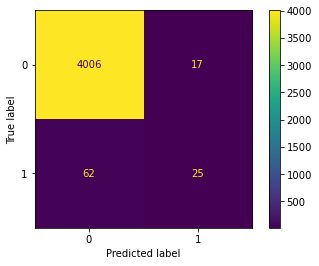

In [7]:
metrics.plot_confusion_matrix(log_reg, X_test, y_test)

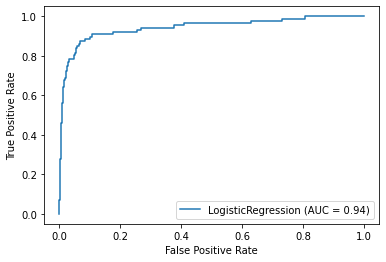

In [8]:
metrics.plot_roc_curve(log_reg, X_test, y_test);

La métrique à ne pas prendre en considération est l'*accuracy* car nous sommes en situation d'*unbalanced dataset*.  
Dans notre cas, le *recall* est plus intéressant.  
Pour bien estimer la performance d'un modèle, on devrait s'intéresser au F1-score qui est un bon compromis entre le recall et la précision.

In [9]:
cross_val_score(log_reg, X, y, cv=5, scoring='f1')

array([0.24137931, 0.41221374, 0.49689441, 0.49056604, 0.43786982])

### GridSearch_CV

Pour tenter de trouver le meilleur modèle possible, on va utiliser un Gridsearch_cv en utilisant un crossvalidation à 5 folds et en utilisant 4 algorithmes : Régression logistique, KNN, Arbre de décisions et SVM

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = [{'name': 'logreg','label': 'Logistic Regression',
           'classifier': LogisticRegression(random_state=SEED),
           'grid': {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}},
          
          {'name': 'knn','label':'K Nearest Neighbors',
           'classifier':KNeighborsClassifier(),
           'grid': {"n_neighbors":np.arange(8)+1}},
          
          {'name': 'dsc','label': 'Descision Tree', 
           'classifier': DecisionTreeClassifier(random_state=SEED),
           'grid': {"max_depth":np.arange(8)+1}},
          
          {'name': 'svm_rbf', 'label': 'SVC (RBF)',
           'classifier':SVC(random_state=SEED),
           'grid': {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}}
        
        ]

In [11]:
def model_selection(classifier, name, grid, X, y, scoring):
    
    gridsearch_cv=GridSearchCV(classifier, 
                               grid,
                               cv=5, 
                               scoring = scoring)
    
    gridsearch_cv.fit(X, y)
    results_dict = {}
    results_dict['classifier_name'] = name    
    results_dict['classifier'] = gridsearch_cv.best_estimator_
    results_dict['best_params'] = gridsearch_cv.best_params_
    results_dict[scoring] = gridsearch_cv.best_score_
    return(results_dict)

results = []
score = 'f1'
for m in models:    
    print(m['name'])    
    results.append(model_selection(m['classifier'], 
                                   m['name'],
                                   m['grid'],
                                   X_train, 
                                   y_train, 
                                   score))      
    print('completed')

logreg
completed
knn
completed
dsc
completed
svm_rbf
completed


In [12]:
results_df = pd.DataFrame(results).sort_values(by=score, ascending = False)
results_df

,classifier_name,classifier,best_params,f1
3,svm_rbf,"SVC(C=100, gamma=0.0001, random_state=22)","{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}",0.491559
2,dsc,"DecisionTreeClassifier(max_depth=8, random_sta...",{'max_depth': 8},0.481640
0,logreg,LogisticRegression(random_state=22),"{'C': 1.0, 'penalty': 'l2'}",0.417739
1,knn,KNeighborsClassifier(n_neighbors=7),{'n_neighbors': 7},0.365325


              precision    recall  f1-score   support

 Not Drafted       0.98      1.00      0.99      4023
     Drafted       0.60      0.29      0.39        87

    accuracy                           0.98      4110
   macro avg       0.79      0.64      0.69      4110
weighted avg       0.98      0.98      0.98      4110



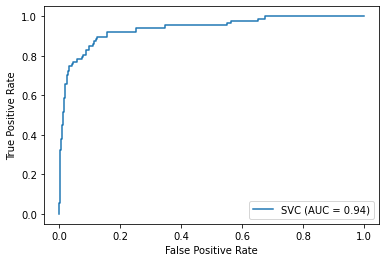

In [13]:
dtc = SVC(C=100, gamma=0.0001, random_state=SEED)  
dtc.fit(X_train, y_train)
target_names = ['Not Drafted', 'Drafted']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))
metrics.plot_roc_curve(dtc, X_test, y_test);

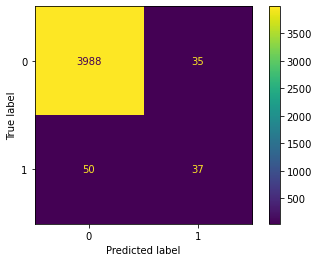

In [14]:
metrics.plot_confusion_matrix(dtc, X_test, y_test)

Malgré, le GridSearchCV on retrouve qu'un f1 score de 0.49 ce qui est moins bon qu'un DummyClassifier.

Use better features, sometimes a domain expert (specific to the problem you're trying to solve) can give relevant pointers that can result in significant improvements.

Use a better classification algorithm and better hyper-parameters.

Over-sample the minority class, and/or under-sample the majority class to reduce the class imbalance.

Use higher weights for the minority class, although I've found over-under sampling to be more effective than using weights.

Choose an optimal cutoff value to convert the continuous valued class probabilities output by your algorithm into a class label. This is as important as a good AUC metric but is overlooked quite often. A word of caution though: the choice of the cutoff should be guided by the users by evaluating the relevant trade-offs.

## Tentative d'amélioration

### PCA

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [22]:
results = []
score = 'f1'
for m in models:    
    print(m['name'])    
    results.append(model_selection(m['classifier'], 
                                   m['name'],
                                   m['grid'],
                                   X_train, 
                                   y_train, 
                                   score))      
    print('completed')

results_df = pd.DataFrame(results).sort_values(by=score, ascending = False)
results_df

logreg
completed
knn
completed
dsc
completed
svm_rbf
completed


,classifier_name,classifier,best_params,f1
3,svm_rbf,"SVC(C=1000, gamma=0.001, random_state=22)","{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",0.521394
0,logreg,"LogisticRegression(C=100.0, random_state=22)","{'C': 100.0, 'penalty': 'l2'}",0.465467
2,dsc,"DecisionTreeClassifier(max_depth=6, random_sta...",{'max_depth': 6},0.366356
1,knn,KNeighborsClassifier(n_neighbors=3),{'n_neighbors': 3},0.346126


              precision    recall  f1-score   support

 Not Drafted       0.98      1.00      0.99      4023
     Drafted       0.60      0.29      0.39        87

    accuracy                           0.98      4110
   macro avg       0.79      0.64      0.69      4110
weighted avg       0.98      0.98      0.98      4110



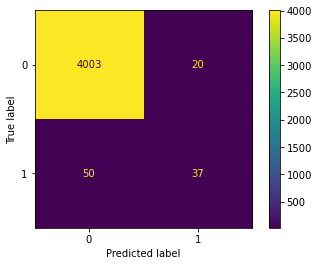

In [32]:
dtc = SVC(C=1000, gamma=0.001, kernel='rbf')  
dtc.fit(X_train, y_train)
target_names = ['Not Drafted', 'Drafted']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))
metrics.plot_confusion_matrix(dtc, X_test, y_test);

Le nombre de faux positifs baisse. 